In [ ]:
# 💳 Aave Credit Score — ML Analysis Notebook
This notebook demonstrates how we analyse and assign credit scores (0–1000) to wallets interacting with Aave V2 using transaction data.

We’ll explore:
- Feature engineering
- Rule-based vs ML credit scoring
- Risk classification (High / Medium / Low)
- Model performance comparison (XGBoost, RF, LinearReg)

In [1]:
# Aave Credit Scoring - ML Demo Notebook

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# Step 1: Load Data
with open("data/user-wallet-transactions.json", "r") as f:
    raw_data = json.load(f)

print(f"Loaded {len(raw_data)} transactions")

Loaded 100000 transactions


In [3]:
# Step 2: Feature Engineering
wallet_actions = defaultdict(lambda: {
    "deposits": 0,
    "borrows": 0,
    "repays": 0,
    "redeems": 0,
    "liquidations": 0
})

for txn in raw_data:
    wallet = txn.get("userWallet") or txn.get("actionData", {}).get("userId")
    if not wallet:
        continue
    action = txn.get("action", "").lower()
    if action == "deposit":
        wallet_actions[wallet]["deposits"] += 1
    elif action == "borrow":
        wallet_actions[wallet]["borrows"] += 1
    elif action == "repay":
        wallet_actions[wallet]["repays"] += 1
    elif action == "redeemunderlying":
        wallet_actions[wallet]["redeems"] += 1
    elif action == "liquidationcall":
        wallet_actions[wallet]["liquidations"] += 1

features_df = pd.DataFrame.from_dict(wallet_actions, orient="index").reset_index()
features_df.rename(columns={"index": "wallet"}, inplace=True)# Step 3: Generate target score (manually like earlier)
def calculate_score(row):
    score = (
        row["deposits"] * 2 +
        row["repays"] * 1.5 -
        row["borrows"] * 1 +
        row["redeems"] * 1.2 -
        row["liquidations"] * 10
    )
    return max(0, min(int(score * 10), 1000))

features_df["score"] = features_df.apply(calculate_score, axis=1)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


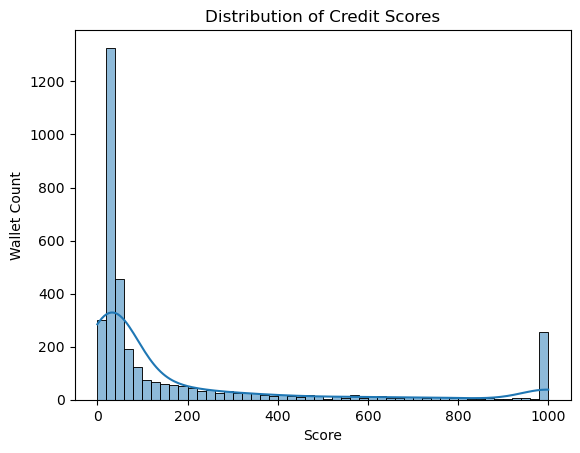

In [4]:
# Step 4: EDA
sns.histplot(features_df["score"], bins=50, kde=True)
plt.title("Distribution of Credit Scores")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.show()

In [5]:
# Step 5: Train-Test Split
X = features_df.drop(columns=["wallet", "score"])
y = features_df["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Step 6: Models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MAE": mae, "R2": r2}
    print(f"{name} | MAE: {mae:.2f} | R²: {r2:.2f}")

LinearRegression | MAE: 203.62 | R²: -36.66
RandomForest | MAE: 10.57 | R²: 0.98
XGBoost | MAE: 9.55 | R²: 0.98


In [7]:
# Step 7: XGBoost
best_model = models["XGBoost"]
features_df["predicted_score"] = best_model.predict(X)

# Clamp scores
features_df["predicted_score"] = features_df["predicted_score"].clip(0, 1000).round(2)

# Risk Category
def classify(score):
    if score >= 700:
        return "Low"
    elif score >= 400:
        return "Medium"
    else:
        return "High"

features_df["risk_category"] = features_df["predicted_score"].apply(classify)

In [8]:
# Final Output
output_df = features_df[["wallet", "predicted_score", "risk_category"]]
output_df.to_csv("output/wallet_scores_ml.csv", index=False)

In [9]:
# Step 8: Sample View
output_df.head()

,wallet,predicted_score,risk_category
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,20.000000,High
1,0x000000000051d07a4fb3bd10121a343d85818da6,20.000000,High
2,0x000000000096026fb41fc39f9875d164bd82e2dc,40.070000,High
3,0x0000000000e189dd664b9ab08a33c4839953852c,203.350006,High
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,999.309998,Low


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


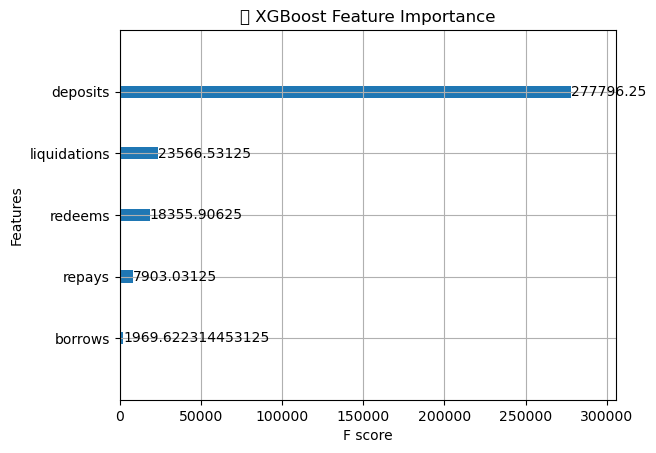

In [15]:
#step 9: plotting
from xgboost import plot_importance
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title("📈 XGBoost Feature Importance")
plt.show()

In [14]:
# Step 10: Model Comparison Table
model_results = pd.DataFrame([
    {"Model": name, "MAE": metrics["MAE"], "R² Score": metrics["R2"]}
    for name, metrics in results.items()
])

# Sort by MAE (lower = better)
model_results = model_results.sort_values(by="MAE").reset_index(drop=True)
print(model_results)

              Model         MAE   R² Score
0           XGBoost    9.552751   0.984738
1      RandomForest   10.570500   0.984024
2  LinearRegression  203.621955 -36.660787
